# Experiments for Time series generation



In [1]:
# automatically reaload libraries (useful when working on libraries while playing with the notebook)
%load_ext autoreload
%autoreload 2

## ARMA models

In [2]:
# allow import from parent directory
import sys,os
sys.path.append(os.getcwd() + '/..')

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
# import helper functions for dataset generation
# from ts_gen import make_binary_code_dataset,make_flat_dataset,make_slopes_dataset
# import helper functions for dataset visualization
from ts_viz import plot_list_of_ts,plot_list_of_ts_over_subplots
# import helper functions to adjust list of series according to output of the clustering
# from ts_utils import get_clustered_list

In [5]:
from dataclasses import dataclass,field
from typing import List



### [Autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model)

the notation AR(p) refers to the autoregressive model of order p. The AR(p) model is written

![AR equation](img/ar.svg)

where $\varphi _{1},\ldots ,\varphi _{p}$ are parameters, c is a constant, and the random variable $\varepsilon _{t}$ is white noise. The value of p is called the order of the AR model.

Some constraints are necessary on the values of the parameters so that the model remains stationary. For example, processes in the AR(1) model with ${\displaystyle |\varphi _{1}|\geq 1}$ are not stationary.

In [6]:
@dataclass
class AR:
    """Auto Regressive time series generator
    AR time series of order p is defined as follows
    Xt = c + phi1 * X(t-1) + phi2 * X(t-2) + ... + phip(t-p) * X(t-p) + error(t)
    
    Params:
    ---------
    coeff : list of p floats, [phi1 , phi2, ... , phip]  
    c     : float, c is the drift constant
    sigma : float, standard deviation of the gaussian random error, with mean = 0
    x_buff: list of floats, keeps memory of the last p elements of the time series. 
            x_buff[0] is the oldest, x_buff[p-1] is the more recent. 
            Empty list by default
    """
    coeff : List[float]
    c     : float = 0.0
    sigma : float = 1.0
    x_buff: List[float] = field(default_factory=list)

    def generate(self, n = 100):
        x = []
        for _ in range(n):
            x.append(self._next_x())
        return x

    def _next_x(self):
        next_e = random.gauss(0,self.sigma)
        next_x = self.c + sum([p*xt for p,xt in zip(self.coeff,self.x_buff[::-1])]) + next_e
        if len(self.coeff) > 0 :
            self.x_buff.append(next_x)
            self.x_buff = self.x_buff[-len(self.coeff):]
        return next_x  

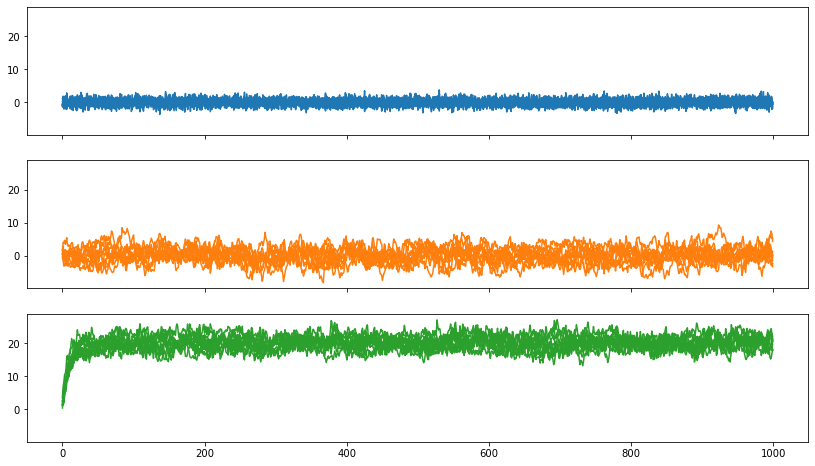

In [7]:
param_list = [{'c' : 0, 'coeff' : []},
              {'c' : 0, 'coeff' : [1,-0.2,0.1]},
              {'c' : 2, 'coeff' : [1,-0.5,0.5,-0.1]},]

samples_per_model = 10

list_of_series = []
for i,params in enumerate(param_list):
    for _ in range(samples_per_model):
        ar = AR(**params)
        list_of_series.append(pd.Series(ar.generate(n=1000),name=i))

plot_list_of_ts_over_subplots(list_of_series,figsize=(14,8));



### [Moving-Average model](https://en.wikipedia.org/wiki/Moving-average_model)

The notation MA(q) refers to the moving average model of order q:

![MA equation](img/ma.svg)

where μ is the mean of the series, the $\theta _{1},\ldots ,\theta _{q}$ are the parameters of the model and the  $\varepsilon _{t}, \varepsilon _{t-1},\ldots ,\varepsilon _{t-q}$ are white noise error terms. The value of q is called the order of the MA model

In [8]:
@dataclass
class MA:
    """Moving Average time series generator
    MA time series of order p is defined as follows
    Xt = mu + error(t) + theta1 * error(t-1) + theta2 * error(t-2) + ... + thetaq * error(t-q)
    
    Params:
    ---------
    coeff : list of q floats, [theta1 , theta2, ... , thetaq]  
    mu    : float, mu is the mean value of the series
    sigma : float, standard deviation of the gaussian random error, with mean = 0
    e_buff: list of floats, keeps memory of the last q values of the error variable. 
            e_buff[0] is the oldest, e_buff[q-1] is the more recent. 
            Empty list by default
    """
    coeff : List[float] = field(default_factory=list)
    mu    : float = 0.0
    sigma : float = 1.0
    e_buff: List[float] = field(default_factory=list)

    def generate(self, n = 100):
        x = []
        for _ in range(n):
            x.append(self._next_x())
        return x

    def _next_x(self):
        next_e = random.gauss(0,self.sigma)
        next_x = self.mu + next_e + sum([q*et for q,et in zip(self.coeff,self.e_buff[::-1])])
        if len(self.coeff) > 0 :
            self.e_buff.append(next_e)
            self.e_buff = self.e_buff[-len(self.coeff):]
        return next_x
        

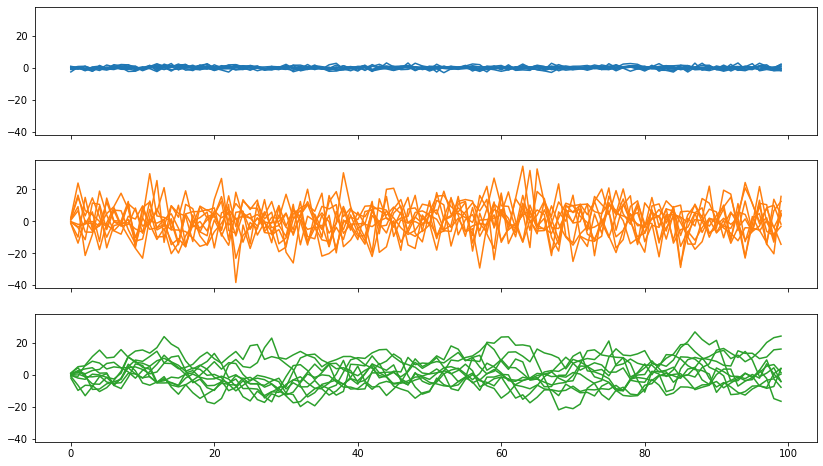

In [9]:
param_list = [{'mu' : 0, 'coeff' : []},
              {'mu' : 0, 'coeff' : [10]},
              {'mu' : 0, 'coeff' : [5,4,3,3,3,3,2,1]}]

samples_per_model = 10

list_of_series = []
for i,params in enumerate(param_list):
    for _ in range(samples_per_model):
        ma = MA(**params)
        list_of_series.append(pd.Series(ma.generate(),name=i))

plot_list_of_ts_over_subplots(list_of_series,figsize=(14,8));



### [Auto-Regressive Moving-Average model](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model)

The notation ARMA(p, q) refers to the model with p autoregressive terms and q moving-average terms. This model contains the AR(p) and MA(q) models,

![ARMA equation](img/arma.svg)

where $\varphi _{1},\ldots ,\varphi _{p}$ are parameters of the AR component, c is a constant, the $\theta _{1},\ldots ,\theta _{q}$ are the parameters of the MA model and the $\varepsilon _{t}, \varepsilon _{t-1},\ldots ,\varepsilon _{t-q}$  are white noise error terms. The vaues (p,q) are called the AR and MA orders of the ARMA model.

The ARMA model is essentially an infinite impulse response filter applied to white noise, with some additional interpretation placed on it.



In [10]:
@dataclass
class ARMA:
    """Auto Regressive Moving Average time series generator
    ARMA time series of orders (p,q) is defined as follows
    Xt = c + error(t) + phi1 * X(t-1) + phi2 * X(t-2) + ... + phip(t-p) * X(t-p) + 
                        theta1 * error(t-1) + theta2 * error(t-2) + ... + thetaq * error(t-q)
    
    Params:
    ---------
    pcoeff : list of p floats, [phi1 , phi2, ... , phip]  
    qcoeff : list of q floats, [theta1 , theta2, ... , thetaq]  
    c      : float, c is the drift constant
    sigma  : float, standard deviation of the gaussian random error, with mean = 0
    e_buff: list of floats, keeps memory of the last q values of the error variable. 
            e_buff[0] is the oldest, e_buff[q-1] is the more recent. 
            Empty list by default
    x_buff: list of floats, keeps memory of the last p elements of the time series. 
            x_buff[0] is the oldest, x_buff[p-1] is the more recent. 
            Empty list by default
            
    """
    pcoeff : List[float] = field(default_factory=list)
    qcoeff : List[float] = field(default_factory=list)
    c      : float = 0.0
    sigma  : float = 1.0
    e_buff : List[float] = field(default_factory=list)
    x_buff : List[float] = field(default_factory=list)

    def generate(self, n = 100):
        x = []
        for _ in range(n):
            x.append(self._next_x())
        return x

    def _next_x(self):
        next_e = random.gauss(0,self.sigma)
        next_x = self.c + sum([p*xt for p,xt in zip(self.pcoeff,self.x_buff[::-1])]) 
        next_x += next_e + sum([q*et for q,et in zip(self.qcoeff,self.e_buff[::-1])])
        if len(self.pcoeff) > 0 :
            self.x_buff.append(next_x)
            self.x_buff = self.x_buff[-len(self.pcoeff):]
        if len(self.qcoeff) > 0 :
            self.e_buff.append(next_e)
            self.e_buff = self.e_buff[-len(self.qcoeff):]
        return next_x

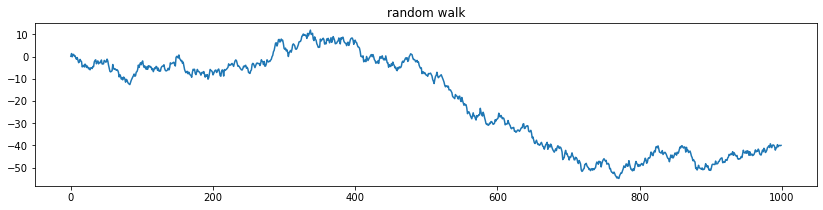

In [11]:
model = ARMA(c=0,pcoeff=[1],qcoeff=[])
s1 = pd.Series(model.generate(1000))
s1.plot(title='random walk',figsize=(14,3));

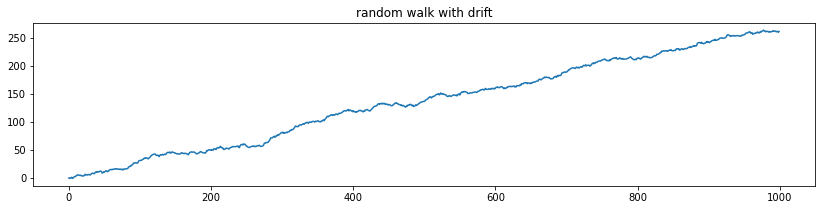

In [12]:
model = ARMA(c=0.3,pcoeff=[1],qcoeff=[])
s1 = pd.Series(model.generate(1000))
s1.plot(title='random walk with drift',figsize=(14,3));

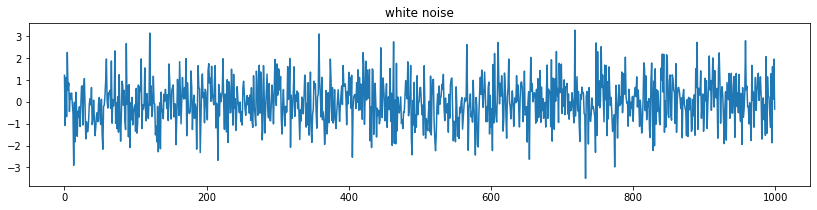

In [13]:
model = ARMA(c=0,pcoeff=[],qcoeff=[])
s1 = pd.Series(model.generate(1000))
s1.plot(title='white noise',figsize=(14,3));

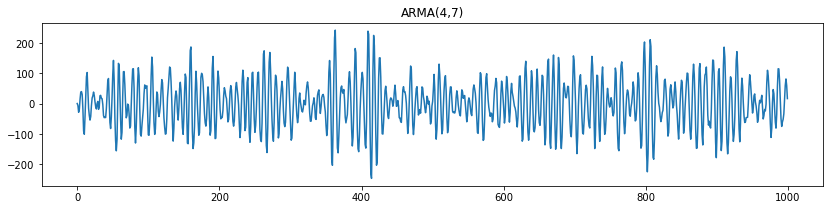

In [14]:
model = ARMA(c=0,pcoeff=[1,-1,0.5,-0.5],qcoeff=[-11,-10,-5,0,5,10,11])
s1 = pd.Series(model.generate(1000))
s1.plot(title=f'ARMA({len(model.pcoeff)},{len(model.qcoeff)})',figsize=(14,3));

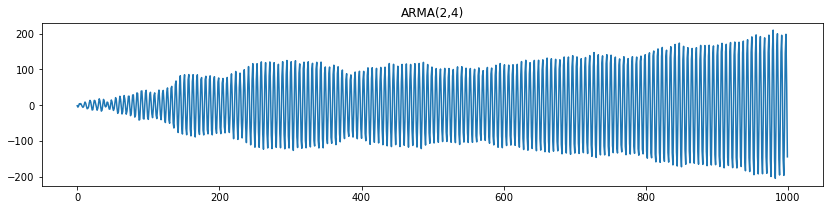

In [15]:
model = ARMA(c=0,pcoeff=[1,-1],qcoeff=[2,-2,1,-1])
s1 = pd.Series(model.generate(1000))
s1.plot(title=f'ARMA({len(model.pcoeff)},{len(model.qcoeff)})',figsize=(14,3));

### Credits

notebook by Marcello Morchio 2021

repository https://github.com/mallibus/pynuTS